# Graph net for node classification

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [15]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam, SGD
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

from reco.model import DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import GraphClassificationLoss, GraphClassificationLossSingleClass
from reco.datasetPU import TracksterGraph

import torch_geometric.nn as gnn


# TODO: for PU, I trained on 10GeV and evaluated on 5Gev
# Retrain when larger dataset is ready (100E)
ds_name = "MultiParticle"

data_root = "/mnt/ceph/users/ecuba/processed"
raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [16]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
def knn_transform(data):
    # pos coordinates are on position 3:6
    data.edge_index = knn_graph(data.pos, k=4, loop=False)
    return data

def prepend_pos(data):
    # GravNet: add S to the front
    data.x = torch.hstack((data.pos, data.x))
    return data

transforms = T.Compose([prepend_pos])

In [28]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=5,
    pileup=False,
    radius=30,
    bigT_e_th=10,
)
ds

TracksterGraph(graphs=17640, nodes=1228188, radius=30, bigT_e_th=10)

In [29]:
ds_size = len(ds)
test_set_size = ds_size // 20
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)

Train graphs: 16758, Test graphs: 882, total: 17640


In [30]:
class TracksterGraphNet(nn.Module):
    def __init__(self, input_dim, output_dim=2, dropout=0.2):
        super(TracksterGraphNet, self).__init__()

        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 64
        hdim2 = 64

        hdim_fc = 256

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2)
        # self.edgeconv3 = DynamicEdgeConvBlock(hdim2, hdim3)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(hdim2, hdim_fc),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
            # nn.Sigmoid(),
            nn.Softmax(dim=1),
        )

    def forward(self, X, batch=None):
        H0 = X #self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch)
        H2 = self.edgeconv2(H1, batch)
        # H3 = self.edgeconv3(H2, batch)
        return self.nodenetwork(H2).squeeze(-1)

In [31]:
def train_graph_classification(model, device, optimizer, loss_func, train_dl):
    train_loss = 0.
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

    return train_loss

In [32]:
@torch.no_grad()
def test_graph_classification(model, device, loss_func, test_dl):
    test_loss = 0.
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.batch)
        loss = loss_func(seg_pred, data)
        test_loss += loss.item()
    return test_loss

In [33]:
model = TracksterGraphNet(input_dim=ds.data.x.shape[1], output_dim=2)
epochs = 51
model_path = f"models/TracksterGraphNet.ParticleNetLight.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [34]:
# %%script echo skipping
# alpha - percentage of negative edges
loss_func = GraphClassificationLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_graph_classification(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 5 == 0:
        test_loss = test_graph_classification(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

Epoch 0:	 train loss: 905.047	 validation loss: 39.114
Epoch 5:	 train loss: 564.434	 validation loss: 64.893
Epoch 10:	 train loss: 536.531	 validation loss: 28.295
Epoch 15:	 train loss: 513.420	 validation loss: 27.445
Epoch 20:	 train loss: 496.462	 validation loss: 26.553
Epoch 25:	 train loss: 478.326	 validation loss: 27.169
Epoch 30:	 train loss: 458.151	 validation loss: 28.032
Epoch 35:	 train loss: 444.365	 validation loss: 26.515
Epoch 40:	 train loss: 433.819	 validation loss: 26.923
Epoch 45:	 train loss: 423.522	 validation loss: 27.465


models/TracksterGraphNet.ParticleNetLight.ns.51e-MultiParticle.r30.e10.f5.pt


Epoch 50:	 train loss: 423.399	 validation loss: 26.890


In [35]:
%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

skipping


0.9180264050051954


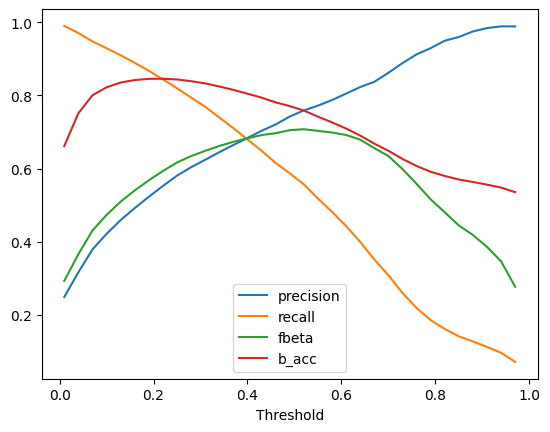

TP: 6097, TN: 47087, FP: 1938, FN: 4851
TH: 0.52 precision: 0.759 recall: 0.557 fbeta: 0.708 b_acc: 0.759


In [36]:
#%%script echo skipping - only evaluating foreground
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=0.5, step=3, truth_threshold=0.5)

## Eval

In [40]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation
from reco.dummy import DummyPleaser

file_name = f"{raw_dir}/new_ntuples_15163313_1.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [ ]:
r_ranges = [5, 10, 20, 30]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []

for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")

    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model.to("cpu"),
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=5,
        pileup=False,
        graph=True,
    )
    
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.991 R: 0.148 F: 0.464
	target_to_sim:	P: 0.998 R: 0.033 F: 0.145
	reco_to_sim:	P: 0.996 R: 0.038 F: 0.165
	|S| = 10 |T| = 2 |R| = 1
Event 1:
	clue3d_to_sim:	P: 0.956 R: 0.093 F: 0.335
	target_to_sim:	P: 0.982 R: 0.021 F: 0.098
	reco_to_sim:	P: 0.979 R: 0.023 F: 0.105
	|S| = 10 |T| = 2 |R| = 1
Event 2:
	clue3d_to_sim:	P: 0.991 R: 0.189 F: 0.536
	target_to_sim:	P: 0.956 R: 0.024 F: 0.109
	reco_to_sim:	P: 0.981 R: 0.030 F: 0.132
	|S| = 10 |T| = 2 |R| = 2
Event 3:
	clue3d_to_sim:	P: 0.975 R: 0.177 F: 0.513
	target_to_sim:	P: 0.993 R: 0.052 F: 0.213
	reco_to_sim:	P: 0.990 R: 0.052 F: 0.214
	|S| = 10 |T| = 2 |R| = 1
Event 4:
	clue3d_to_sim:	P: 0.963 R: 0.095 F: 0.340
	target_to_sim:	P: 0.986 R: 0.019 F: 0.086
	reco_to_sim:	P: 0.938 R: 0.023 F: 0.105
	|S| = 10 |T| = 2 |R| = 1
Event 5:
	clue3d_to_sim:	P: 0.979 R: 0.136 F: 0.437
	target_to_sim:	P: 0.996 R: 0.028 F: 0.126
	reco_to_sim:	P: 0.996 R: 0.028 F: 0.126
	|S| = 10 |T| = 1 |R| = 1

In [ ]:
print(clue3D_F)
print(target_F)
print(model_reco_F)

In [ ]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:6], (np.array(target_F) - np.array(clue3D_F))[:6], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:6], (np.array(model_reco_F) - np.array(clue3D_F))[:6], '-o', label="GNN $\Delta F_{0.5}$", c="#56B4E9")
# ax.plot(r_ranges[:6], (np.array(naive_reco_F) - np.array(clue3D_F))[:6], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

#ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
# ax.set_ylim((-0.1, 0.1))

fig.savefig(f'export/{ds_name}-e30-pnetl-graph-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
# print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796